In [1]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
import torch

C:\Users\박해극\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 메모리 삭제
torch.cuda.empty_cache()

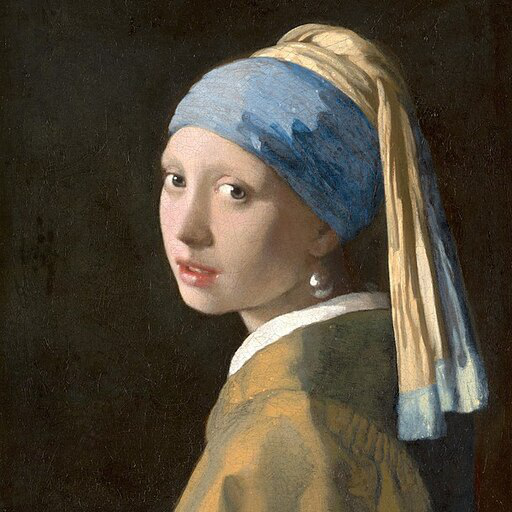

In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

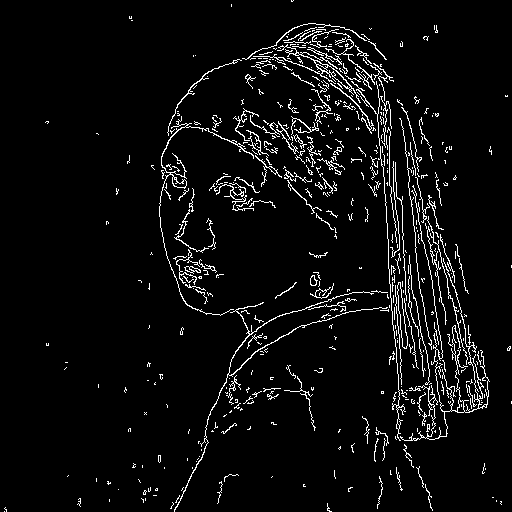

In [5]:
import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|                                                            | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.87it/s]


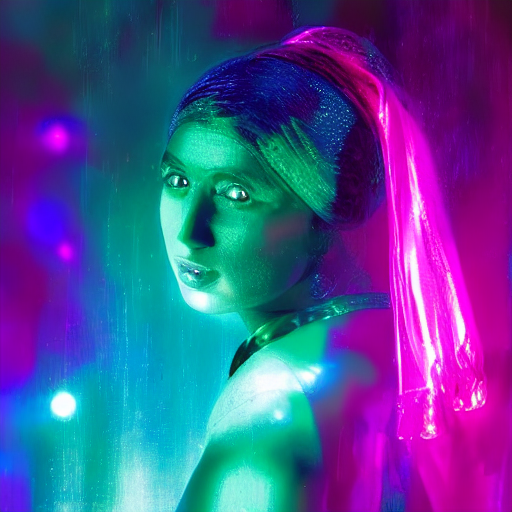

In [7]:
import os
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
cwd = os.getcwd()
canny_image.save(os.path.join(cwd, "canny_image.png"))  

# 생성된 이미지를 출력합니다. 
canny_image

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.76it/s]


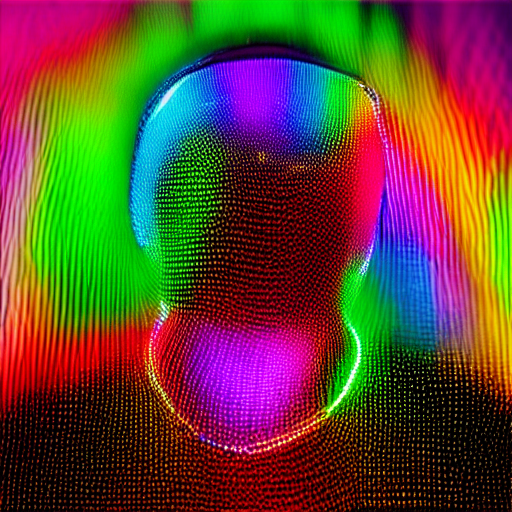

In [8]:
# 이미지를 생성합니다. 
canny_image_v2 = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20,
    negative_prompt="sad dancer",
    controlnet_conditioning_scale=0.8,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다.
cwd = os.getcwd()
canny_image_v2.save(os.path.join(cwd, "canny_image_v2.png"))  

# 생성된 이미지를 출력합니다. 
canny_image_v2

## **인체 자세 감지**

In [9]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


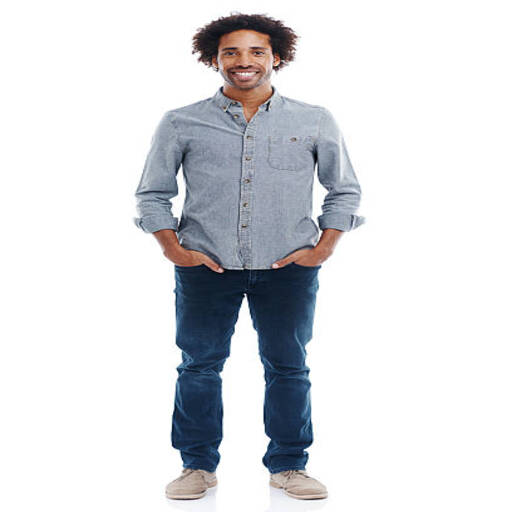

In [10]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


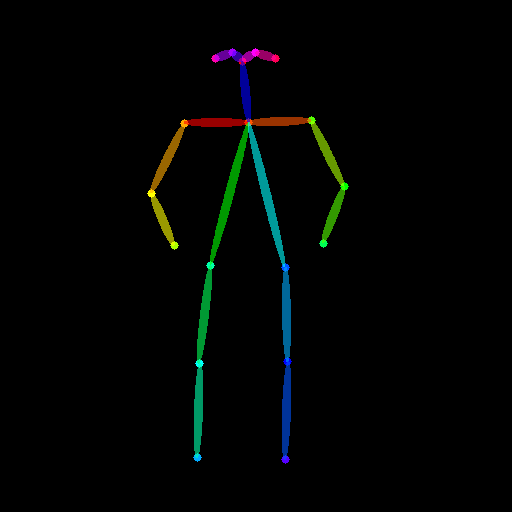

In [11]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|                                                            | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.75it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


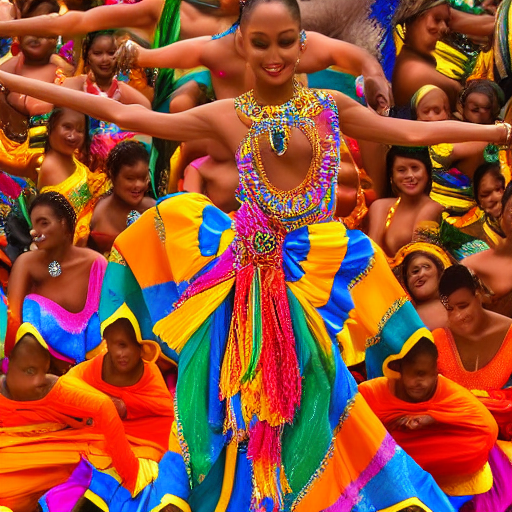

In [13]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
seed = 42 
generator = torch.Generator("cuda").manual_seed(seed)

#프롬프트를 작성합니다. 
prompt =  "a vibrant dancer that lets off streams of bliss from every angle"
negative_prompt =  "crazy, mad, insane"

images = openpose_image

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt=prompt, 
    num_inference_steps=20,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=0.8,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

## **하이퍼파라미터 재설정**

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.77it/s]


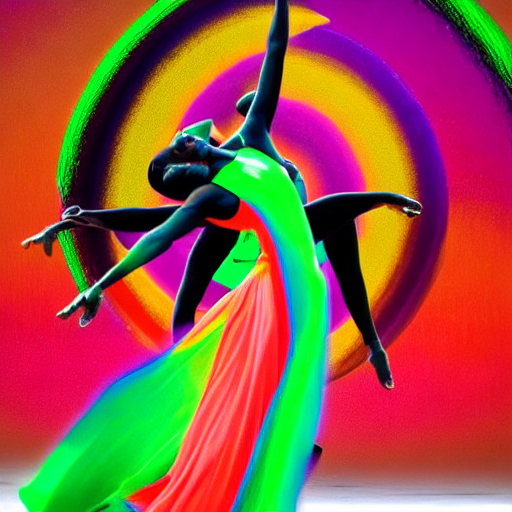

In [14]:
# 이미지를 생성합니다. 
openpose_image2 = openpose_pipe(
    prompt=prompt, 
    num_inference_steps=20,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=0.8,
    guidance_scale=9,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image2

In [15]:
# # Seed for reproducibility
# seed = 42  # You can choose any number as a seed
# generator = torch.Generator("cuda").manual_seed(seed)

# # Writing the prompts
# prompt = "a person in a dynamic pose"  # Describe the pose or scene you want
# negative_prompt = "low quality, blurry images"  # Describe what you don't want in the image

# # Generating the image
# openpose_image1 = openpose_pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=50, generator=generator).images[0]

# # Display the generated image
# openpose_image1.show()

## **윤곽선 검출+인체 자세 감지**

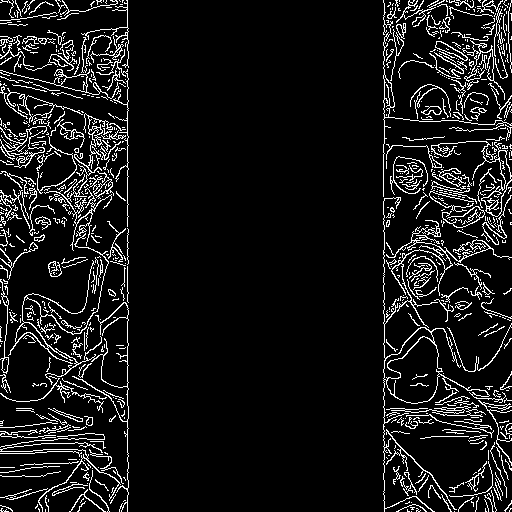

In [16]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요.
cwd = os.getcwd()
openpose_image1.save(os.path.join(cwd, "openpose.png")) 
canny_image_beta = openpose_image1
# canny_image = openpose_image2

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image_beta = np.array(canny_image_beta)
canny_image_beta.shape

if canny_image_beta.dtype != np.uint8:
    canny_image_beta = canny_image_beta.astype(np.uint8)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image_beta.shape[1] // 4
zero_end = zero_start + canny_image_beta.shape[1] // 2
canny_image_beta[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image_beta = cv2.Canny(canny_image_beta, low_threshold, high_threshold)
canny_image_beta = np.stack((canny_image_beta,)*3, axis=-1)
canny_image_beta = Image.fromarray(canny_image_beta)

canny_image_beta

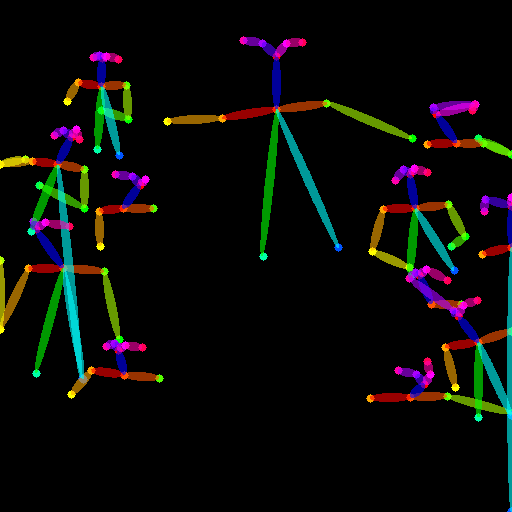

In [17]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
cwd = os.getcwd()
openpose_image_path = os.path.join(cwd, "openpose.png")
openpose_image = Image.open(openpose_image_path)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose_beta = openpose(openpose_image)
openpose_beta

In [22]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
controlnets = [canny_controlnet, openpose_controlnet]

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt =  "a vibrant dancer that lets off streams of bliss from every angle"
negative_prompt =  "insane like Donald Trump"

# seed를 지정합니다. 
seed = 42
generator = torch.Generator("cuda").manual_seed(seed)

openpose_image_np = np.array(openpose_beta)
canny_image_np = np.array(canny_image_beta)

openpose_image_tensor = torch.tensor(openpose_image_np).float()
canny_image_tensor = torch.tensor(canny_image_np).float()

images = [openpose_image_tensor, canny_image_tensor]

# 이미지를 생성합니다. 
image = pipe(prompt=prompt, 
            negative_prompt=negative_prompt, 
            generator=generator,
            image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

Loading pipeline components...:   0%|                                                            | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:02<00:00,  2.87it/s]


ValueError: If image batch size is not 1, image batch size must be same as prompt batch size. image batch size: 512, prompt batch size: 1